# Emotion Classification with the WASSA-2022 emotion dataset

In this notebook, we will use a state of the art technique from [AdityaPatkar](https://aclanthology.org/2023.wassa-1.46/) to perform emotion classification using the WASSA 2022 emotion dataset. The authors utilize a fine-tuned RoBERTa model and achieved state of the art performance through the usage of complex feature engineering and overfitting techniques. We will attempt to replicate their results using a similar approach.

## Imports and Constants

In [37]:
import transformers
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.optim.swa_utils import AveragedModel, SWALR

# Constant value due to memory constraints
# Should roughly fit in Batch size/2 GBs of VRAM with our implementation
BATCH_SIZE = 16


## Loading the Dataset

We observe that the dataset is a csv file, however semi-colons are used as a separator. Additionally, the labels need to be mapped to numerical values. We will load the dataset and perform these operations.

In [38]:
# Load the dataset
train = pd.read_csv('train_ready_for_WS.csv', encoding='utf-8', sep=';')
test = pd.read_csv('test.csv', encoding='utf-8', sep=';')

train.head()

,article_id,essay,emotion
0,67,it is really diheartening to read about these ...,sadness
1,86,the phone lines from the suicide prevention li...,sadness
2,206,"no matter what your heritage, you should be ab...",neutral
3,290,it is frightening to learn about all these sha...,fear
4,342,the eldest generation of russians aren't being...,sadness


In [39]:
# Obtain emotion mapping from the dataset
emotions = train['emotion'].unique()
emotion_map = {emotion: idx for idx, emotion in enumerate(emotions)}

# Convert map to dataframe
emotion_map_df = pd.DataFrame(emotion_map.items(), columns=['emotion', 'label'])
emotion_map_df

,emotion,label
0,sadness,0
1,neutral,1
2,fear,2
3,anger,3
4,disgust,4
5,surprise,5
6,joy,6


In [40]:
# Apply the mapping to the datasets
train_encoded = train.copy()
train_encoded['emotion'] = train_encoded['emotion'].map(emotion_map)

test_encoded = test.copy()
test_encoded['emotion'] = test_encoded['emotion'].map(emotion_map)

train_encoded.head()

,article_id,essay,emotion
0,67,it is really diheartening to read about these ...,0
1,86,the phone lines from the suicide prevention li...,0
2,206,"no matter what your heritage, you should be ab...",1
3,290,it is frightening to learn about all these sha...,2
4,342,the eldest generation of russians aren't being...,0


## Exploratory Data Analysis

We will perform some basic exploratory data analysis to understand the dataset better. This will include visualizing the distribution of the labels, and the distribution of the number of words in the text. To prevent data leakage, we will only examine the training set.

<Axes: xlabel='emotion', ylabel='count'>

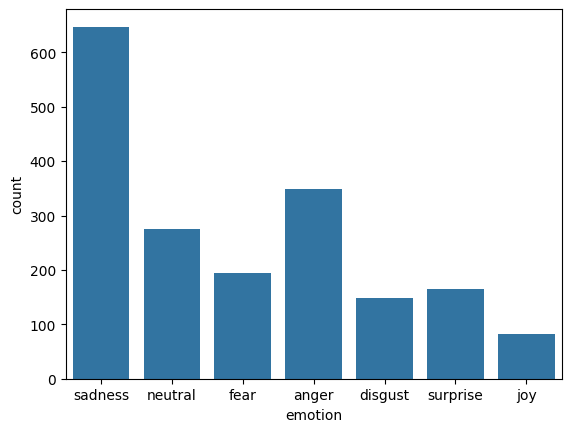

In [41]:
# Plot the distribution of the emotions, emotion is a categorical variable
sns.countplot(x=train['emotion'])

In [42]:
# Check for NA values
print(train.isna().sum())

article_id    0
essay         0
emotion       0
dtype: int64


<Axes: xlabel='Number of Words', ylabel='Count'>

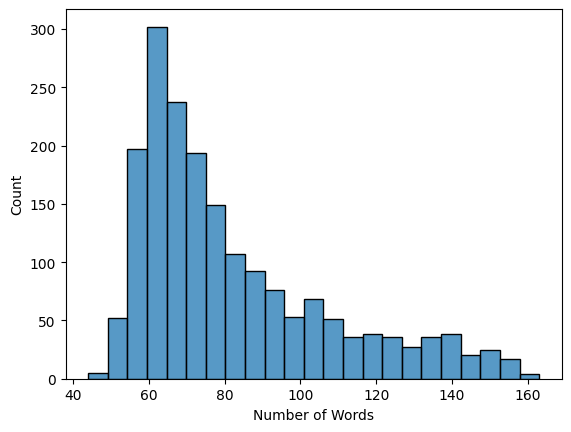

In [43]:
# Plot the distribution of number of words in an essay
train['Number of Words'] = train['essay'].apply(lambda x: len(x.split()))
sns.histplot(train['Number of Words'])

From this basic investigation, we observe that there is a severe class imbalance in the dataset. Additionally, the size of an essay varies greatly with the average hovering around 60 words. We can easily address this issue using a transformer model which can handle variable length inputs due to its attention mechanism.

## Preprocessing

We are using transformers which require minimal text pre-processing as they are designed to handle raw text. However, we will need to tokenize the text and convert it to a format that the model can understand. We will also need to address the class imbalance in the dataset using class weights. Additionally, we will split the training set into a training and validation set.

In [44]:
# Compute the class weights and add to the mapping dataframe
# We compute the class weights as w_i = N / (k * n_i)
# where N is the total number of samples, k is the number of classes and n_i is the number of samples in class i

# Compute class counts
class_counts = train['emotion'].value_counts()
class_weights = len(train) / (len(emotions) * class_counts)


# Convert to dataframe
class_weights_df = pd.DataFrame(class_weights)
class_weights_df.reset_index(inplace=True)
class_weights_df.columns = ['emotion', 'count']

print(emotion_map_df)
print(class_weights_df)

print(type(class_weights_df['emotion'][0]))
print(type(emotion_map_df['emotion'][0]))

# Merge with emotion_map_df using emotion column
emotion_map_df = emotion_map_df.merge(class_weights_df, on='emotion')
emotion_map_df

    emotion  label
0   sadness      0
1   neutral      1
2      fear      2
3     anger      3
4   disgust      4
5  surprise      5
6       joy      6
    emotion     count
0   sadness  0.410687
1     anger  0.761359
2   neutral  0.966234
3      fear  1.369661
4  surprise  1.620209
5   disgust  1.783317
6       joy  3.240418
<class 'str'>
<class 'str'>


,emotion,label,count
0,sadness,0,0.410687
1,neutral,1,0.966234
2,fear,2,1.369661
3,anger,3,0.761359
4,disgust,4,1.783317
5,surprise,5,1.620209
6,joy,6,3.240418


In [45]:
for idx, row in emotion_map_df.iterrows():
    train_encoded.loc[train_encoded['emotion'] == row['label'], 'class_weight'] = row['count']
    test_encoded.loc[test_encoded['emotion'] == row['label'], 'class_weight'] = row['count']

train_encoded.head()

,article_id,essay,emotion,class_weight
0,67,it is really diheartening to read about these ...,0,0.410687
1,86,the phone lines from the suicide prevention li...,0,0.410687
2,206,"no matter what your heritage, you should be ab...",1,0.966234
3,290,it is frightening to learn about all these sha...,2,1.369661
4,342,the eldest generation of russians aren't being...,0,0.410687


In [46]:
# Split the dataset into training and validation
train_df, val_df = train_test_split(train_encoded, test_size=0.3)

In [47]:
# Create pytorch dataset
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        # Get max length from tokenizer
        self.max_length = tokenizer.model_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        essay = self.data.iloc[idx]['essay']
        label = self.data.iloc[idx]['emotion']
        weight = self.data.iloc[idx]['class_weight']

        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'essay': essay,
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'label': torch.tensor(label, dtype=torch.long),
            'weight': torch.tensor(weight, dtype=torch.float)
        }

In [48]:
def emotion_collate(batch):

    input_ids = [item['input_ids'].squeeze(0) for item in batch]  # List of tensors
    attention_mask = [item['attention_mask'].squeeze(0) for item in batch]  # List of tensors
    label = torch.stack([item['label'] for item in batch])
    weight = torch.stack([item['weight'] for item in batch])

    # Pad the input_ids and attention_mask
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'label': label,
        'weight': weight
    }

In [49]:
# Create Dataloader which is used to iterate over the dataset
def create_dataloader(data, tokenizer, batch_size):
    dataset = EmotionDataset(data, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=emotion_collate)

In [50]:
# Obtain roberta tokenizer and create dataloader for dataset
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
train_loader = create_dataloader(train_df, tokenizer, BATCH_SIZE)
val_loader = create_dataloader(val_df, tokenizer, BATCH_SIZE)
test_loader = create_dataloader(test_encoded, tokenizer, BATCH_SIZE)

## Model Creation

Creation of classes required for the model which take hyperparameters as input. Note that RoBERTa is case sensitive which is why we did not convert the text to lowercase during preprocessing.

In [51]:
def process_batch(model, device, batch):
    """
    Process a batch by using the input_ids and attention_mask
    Returns the loss and the number of correct predictions
    """
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    # Get number of correct predictions
    preds = torch.argmax(outputs.logits, dim=1)
    correct_predictions = (preds == labels).float()

    # Get the loss taking class weights into account
    loss = outputs.loss * batch['weight'].to(device)
    loss = loss.mean()

    return loss, correct_predictions


In [52]:
def train_model(model, optimizer, device, dataset):
    """
    Train the model
    """
    model.train()
    total_loss = 0
    for batch in dataset:
        optimizer.zero_grad()
        loss, _ = process_batch(model, device, batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataset)

In [53]:
def evaluate_model(model, device, dataset):
    """
    Evaluate the model
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataset:
            loss, _ = process_batch(model, device, batch)
            total_loss += loss.item()
    return total_loss / len(dataset)

In [58]:
def train_configuration(model, swa_model, optimizer, swa_optimizer, device, train_loader, val_loader, epochs):
    """
    Train the model for a number of epochs and return the train and validation losses
    """


    train_losses = []
    val_losses = []
    swa_val_losses = []


    for epoch in range(epochs):
        train_loss = train_model(model, optimizer, device, train_loader)
        val_loss = evaluate_model(model, device, val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        swa_model.update_parameters(model)

        if epoch == epochs - 1:
          torch.optim.swa_utils.update_bn(train_loader, swa_model)

        swa_val_loss = evaluate_model(swa_model, device, val_loader)
        swa_val_losses.append(swa_val_loss)

    return train_losses, val_losses, swa_val_losses

## Model Training

Training loop with hyperparameter tuning

In [59]:
hyperparameters = {
#    "learning_rate": [1e-5, 2e-5, 3e-5, 4e-5],
#    "epochs": [3, 5, 10]
     "learning_rate": [1e-5, 2e-5],
     "epochs": [3]
}

In [63]:
# Create a dataframe to store the hyperparameters and the corresponding losses
# Use the hyper-parameter keys as columns

model_configuration_df = pd.DataFrame(columns=list(hyperparameters.keys()) + ['train_losses', 'val_losses'])
swa_model_configuration_df = pd.DataFrame(columns=list(hyperparameters.keys()) + ['swa_val_losses'])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate over the hyperparameters combinations and train the model
# The combination is be a dictionary with the same keys as the hyperparameters dictionary
for combination in tqdm(list(itertools.product(*hyperparameters.values())), desc='Hyperparameter combinations'):

    # Create a dictionary with the hyperparameters
    params = {key: value for key, value in zip(hyperparameters.keys(), combination)}
    print(params)

    # Train the model
    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=len(emotions))
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'])
    swa_optimizer = torch.optim.swa_utils.SWALR(optimizer, swa_lr=1e-5)
    swa_model = AveragedModel(model)
    model.to(device)
    swa_model.to(device)

    # Train the model and obtain the train and validation losses
    train_losses, val_losses, swa_val_losses = train_configuration(model, swa_model, optimizer, swa_optimizer, device, train_loader, val_loader, epochs=params['epochs'])

    print(val_losses)
    print(swa_val_losses)
    # Add the hyperparameters and the corresponding losses to the dataframe
    model_configuration_df.loc[len(model_configuration_df)] = list(params.values()) + [train_losses, val_losses]
    swa_model_configuration_df.loc[len(swa_model_configuration_df)] = list(params.values()) + [swa_val_losses]




Hyperparameter combinations:   0%|          | 0/2 [00:00<?, ?it/s]

{'learning_rate': 1e-05, 'epochs': 3}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[1.8970929316111973, 1.4069659386362348, 1.292285200527736]
[1.9054273435047695, 1.6545004623276847, 1.5018980094364711]
{'learning_rate': 2e-05, 'epochs': 3}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[1.4478814542293548, 1.2841152037893022, 1.2434179084641592]
[1.4334089466503688, 1.3016063622065952, 1.2300946814673288]


In [64]:
def plot_losses(train_losses, val_losses, swa_val_losses):

    # Plot the training and validation losses
    plt.plot(train_losses, label='Training')
    plt.plot(val_losses, label='Validation')
    plt.plot(swa_val_losses, label='SWA')
    plt.legend()

    # Label the axes and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')

    # Make x axis discrete
    plt.xticks(range(len(train_losses)))
    plt.show()

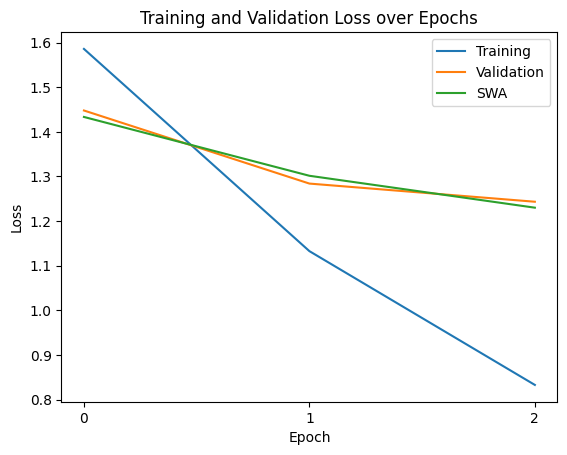

In [67]:
# Create a new column 'last_val_loss' that contains the last validation loss for each row
model_configuration_df['last_val_loss'] = model_configuration_df['val_losses'].apply(lambda x: x[-1])
swa_model_configuration_df['last_val_loss'] =  swa_model_configuration_df['swa_val_losses'].apply(lambda x: x[-1])


# Sort the DataFrame by the 'last_val_loss' column
sorted_df = model_configuration_df.sort_values(by='last_val_loss', ascending=True)
best_configuration = sorted_df.iloc[0]

# Sort the DataFrame by the 'last_val_loss' column
swa_sorted_df = swa_model_configuration_df.sort_values(by='last_val_loss', ascending=True)
swa_best_configuration = swa_sorted_df.iloc[0]

# Plot the losses for the best configuration
plot_losses(best_configuration['train_losses'], best_configuration['val_losses'], swa_best_configuration['swa_val_losses'])

# Save sorted_df to a csv file
sorted_df.to_csv('sorted_df.csv', index=False)

## Model Evaluation

Macro F1 score, Micro F1 score, precision, recall, confusion matrix

In [32]:
# Train the model with the best hyperparameters
best_model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=len(emotions))
optimizer = torch.optim.AdamW(model.parameters(), lr=best_configuration['learning_rate'])
best_model.to(device)

# Train the model again since we cannot store the model from the previous training due to the large size
# Might be a good idea to combine the training and validation datasets when creating a model for testing
train_losses, val_losses = train_configuration(best_model, optimizer, device, train_loader, val_loader, epochs=best_configuration['epochs'])

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Generate predictions here
print(best_configuration)

learning_rate                                              0.00001
epochs                                                           5
train_losses     [1.777057287169666, 1.4714476982267892, 1.1361...
val_losses       [1.7063056366784233, 1.226293592793601, 1.1180...
last_val_loss                                             1.091842
Name: 1, dtype: object


In [33]:
print(train_losses, val_losses)

[1.9928834772691495, 1.9947047408034162, 2.004243856523095, 1.997044967442024, 1.994382695453923] [2.038290343965803, 2.039507130214146, 2.037754896708897, 2.0413792780467443, 2.0377426522118705]
